<a href="https://colab.research.google.com/github/Avijit-D/hydration-essentials/blob/main/bottle_model_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and Unzipping Dataset

In [1]:
!kaggle datasets download -d chethuhn/water-bottle-dataset


Dataset URL: https://www.kaggle.com/datasets/chethuhn/water-bottle-dataset
License(s): CC0-1.0
 98% 63.0M/64.2M [00:04<00:00, 25.6MB/s]
100% 64.2M/64.2M [00:04<00:00, 15.9MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('water-bottle-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Dataset Partition

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

def load_images_from_directory(directory, image_size=(256, 256), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        labels='inferred',
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size
    )
    return dataset

image_directory = '/content/archive'
dataset = load_images_from_directory(image_directory)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Found 486 files belonging to 3 classes.
Train dataset size: 12
Validation dataset size: 2
Test dataset size: 2


# Image Preprocessing

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# Resizing and Rescaling
resize_and_rescale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(256, 256),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Data Augmentation
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 12
Validation dataset size: 2
Test dataset size: 2


# Model Building

In [7]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
import logging
logging.basicConfig(level=logging.ERROR, filename= "tensorflow.log", filemode="w")

from keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [8]:
# Importing Keras models and layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation

In [9]:
input_shape = (32, 256, 256, 3)
num_classes = 3

model = Sequential([
    resize_and_rescale,
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),

    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),

    Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# Model Training

In [10]:
model.compile(optimizer='SGD',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
history = model.fit(train_ds,epochs=75,validation_data=val_ds)

Epoch 1/75
12/12 [==============================] - 56s 4s/step - loss: 0.9289 - accuracy: 0.5866 - val_loss: 0.9941 - val_accuracy: 0.6094
Epoch 2/75
12/12 [==============================] - 53s 4s/step - loss: 0.6754 - accuracy: 0.7151 - val_loss: 0.8896 - val_accuracy: 0.7031
Epoch 3/75
12/12 [==============================] - 52s 4s/step - loss: 0.6126 - accuracy: 0.7542 - val_loss: 0.9081 - val_accuracy: 0.6250
Epoch 4/75
12/12 [==============================] - 52s 4s/step - loss: 0.5209 - accuracy: 0.7905 - val_loss: 0.9017 - val_accuracy: 0.5781
Epoch 5/75
12/12 [==============================] - 65s 5s/step - loss: 0.5197 - accuracy: 0.8156 - val_loss: 0.8909 - val_accuracy: 0.6579
Epoch 6/75
12/12 [==============================] - 52s 4s/step - loss: 0.5746 - accuracy: 0.7682 - val_loss: 0.9422 - val_accuracy: 0.5781
Epoch 7/75
12/12 [==============================] - 55s 4s/step - loss: 0.4760 - accuracy: 0.8359 - val_loss: 0.8388 - val_accuracy: 0.5938
Epoch 8/75
12/12 [==

In [13]:
scores = model.evaluate(test_ds)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2/2 [==============================] - 5s 1s/step - loss: 0.0427 - accuracy: 1.0000
Test loss: 0.0427468940615654
Test accuracy: 1.0


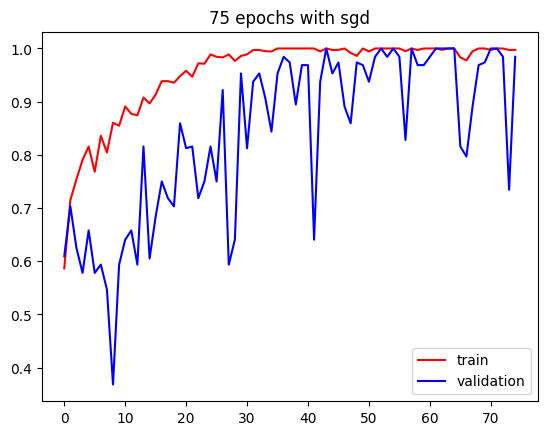

In [14]:
import matplotlib.pyplot as plt
plt.title('75 epochs with sgd')
plt.plot(history. history['accuracy'], color='red' , label= 'train' )
plt.plot(history. history['val_accuracy'], color='blue' , label= 'validation')
plt.legend()
plt.show()

In [ ]:
model.save('modelSGD.h5')
model.save('modelSGD.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
score = model.evaluate(test_ds)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 6s 981ms/step - loss: 4.8766e-04 - accuracy: 1.0000
Test loss: 0.00048766311374492943
Test accuracy: 1.0
